# Imports

In [111]:
import os
import pandas as pd
import json
import numpy as np
import polars as pl
import pyarrow as pa
import seaborn as sb
import math

# Beolvasás & Flattening

In [2]:
def read_json_to_dataframe(filename, df):
    # Read JSON file into DataFrame
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    df = pd.DataFrame(data)

    # Flatten columns with lists
    for column in df.columns:
        if isinstance(df[column][0], list):
            # Expand list into multiple columns
            expanded_columns = pd.json_normalize(df[column])
            expanded_columns.columns = [f"{column}_{col}" for col in expanded_columns.columns]
            df = pd.concat([df, expanded_columns], axis=1)
            # Drop the original column
            df.drop(columns=[column], inplace=True)

    # Display DataFrame
    pd.set_option("display.max_columns", None)
    print(f"File: {filename}, Shape: {df.shape}")
    return df

In [3]:
def flatten_columns_with_dicts(df):
    for column in df.columns:
        # Find the index of the first non-null value in the column
        first_non_null_index = df[column].first_valid_index()
        if first_non_null_index is not None:
            # Check if the value at the first non-null index is a 
            # dictionary
            if isinstance(df[column][first_non_null_index], dict):
                # Expand hierarchical information into multiple columns
                expanded_columns = pd.json_normalize(df[column])
                expanded_columns.columns = [f"{column}_{col}" for col in expanded_columns.columns]
                df = pd.concat([df, expanded_columns], axis=1)
                # Drop the original column
                df.drop(columns=[column], inplace=True)
    print(df.shape)    
    return df

In [5]:
def flatten_columns_with_lists(df):
    for column in df.columns:
        # Find the index of the first non-null value in the column
        first_non_null_index = df[column].first_valid_index()
        if first_non_null_index is not None:
            # Check if the value at the first non-null index is a list
            if isinstance(df[column][first_non_null_index], list):
                # Expand the list into multiple columns
                df = pd.concat([df, df[column].apply(pd.Series).add_prefix(f"{column}_")], axis=1)
                # Drop the original column
                df.drop(columns=[column], inplace=True)
    print(df.shape)
    return df

In [6]:
# Define the file_df_pairs
file_df_pairs = [
    ("data/events/events_England.json", "df_events"),
    ("data/matches/matches_England.json", "df_matches"),
    ("data/players.json", "df_players"),
    ("data/teams.json", "df_teams")
]

# Loop through each filename and DataFrame variable pair
for filename, df_name in file_df_pairs:
    # Read JSON file into DataFrame
    df = pd.DataFrame()
    exec(f"{df_name} = read_json_to_dataframe(filename, df)")

File: data/events/events_England.json, Shape: (643150, 18)
File: data/matches/matches_England.json, Shape: (380, 17)
File: data/players.json, Shape: (3603, 14)
File: data/teams.json, Shape: (142, 6)


In [7]:
df_events = flatten_columns_with_dicts(df_events)
df_players = flatten_columns_with_dicts(df_players)
df_teams = flatten_columns_with_dicts(df_teams)

(643150, 20)
(3603, 22)
(142, 9)


In [8]:
df_matches.head(1)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,duration,competitionId,referees_0,referees_1,referees_2,referees_3
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364,"{'refereeId': 385705, 'role': 'referee'}","{'refereeId': 385733, 'role': 'firstAssistant'}","{'refereeId': 385922, 'role': 'secondAssistant'}","{'refereeId': 388333, 'role': 'fourthOfficial'}"


In [9]:
columns_to_drop = [col for col in df_matches.columns if col.startswith("referees_")]
df_matches.drop(columns=columns_to_drop, inplace=True)

In [10]:
# Function to flatten 'teamsData' column
def flatten_teams_data(row):
    teams_data = row['teamsData']
    team_A = {}
    team_B = {}
    for key, value in teams_data.items():
        if value['side'] == 'home':
            team_A = {
                'teamId': value['teamId'],
                'score': value['score'],
                'coachId': value['coachId'],
                'formation': value['formation'],
                'scoreHT': value['scoreHT']
            }
        else:
            team_B = {
                'teamId': value['teamId'],
                'score': value['score'],
                'coachId': value['coachId'],
                'formation': value['formation'],
                'scoreHT': value['scoreHT']
            }
    return pd.Series({
        'teamA_teamId': team_A.get('teamId', None),
        'teamA_score': team_A.get('score', None),
        'teamA_coachId': team_A.get('coachId', None),
        'teamA_formation': team_A.get('formation', None),
        'teamA_scoreHT': team_A.get('scoreHT', None),
        'teamB_teamId': team_B.get('teamId', None),
        'teamB_score': team_B.get('score', None),
        'teamB_coachId': team_B.get('coachId', None),
        'teamB_formation': team_B.get('formation', None),
        'teamB_scoreHT': team_B.get('scoreHT', None)
    })

In [11]:
# Apply the function to each row to flatten the DataFrame
flattened_df = df_matches.apply(flatten_teams_data, axis=1)
# Concatenate the original DataFrame with the flattened DataFrame
final_df = pd.concat([df_matches, flattened_df], axis=1)
# Drop the original 'teamsData' column
final_df = final_df.drop(columns=['teamsData'])

In [12]:
final_df.head(1)

,status,roundId,gameweek,seasonId,dateutc,winner,venue,wyId,label,date,duration,competitionId,teamA_teamId,teamA_score,teamA_coachId,teamA_formation,teamA_scoreHT,teamB_teamId,teamB_score,teamB_coachId,teamB_formation,teamB_scoreHT
0,Played,4405654,38,181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364,1646,1,8880,"{'bench': [{'playerId': 77502, 'ownGoals': '0'...",1,1659,2,8934,"{'bench': [{'playerId': 11061, 'ownGoals': '0'...",0


In [13]:
df_matches = flatten_columns_with_dicts(final_df)
df_matches = flatten_columns_with_lists(df_matches)
df_matches = flatten_columns_with_dicts(df_matches)

(380, 26)
(380, 62)
(380, 218)


In [14]:
df_matches.head(1)

,status,roundId,gameweek,seasonId,dateutc,winner,venue,wyId,label,date,duration,competitionId,teamA_teamId,teamA_score,teamA_coachId,teamA_scoreHT,teamB_teamId,teamB_score,teamB_coachId,teamB_scoreHT,teamA_formation_bench_0_playerId,teamA_formation_bench_0_ownGoals,teamA_formation_bench_0_redCards,teamA_formation_bench_0_goals,teamA_formation_bench_0_yellowCards,teamA_formation_bench_1_playerId,teamA_formation_bench_1_ownGoals,teamA_formation_bench_1_redCards,teamA_formation_bench_1_goals,teamA_formation_bench_1_yellowCards,teamA_formation_bench_2_playerId,teamA_formation_bench_2_ownGoals,teamA_formation_bench_2_redCards,teamA_formation_bench_2_goals,teamA_formation_bench_2_yellowCards,teamA_formation_bench_3_playerId,teamA_formation_bench_3_ownGoals,teamA_formation_bench_3_redCards,teamA_formation_bench_3_goals,teamA_formation_bench_3_yellowCards,teamA_formation_bench_4_playerId,teamA_formation_bench_4_ownGoals,teamA_formation_bench_4_redCards,teamA_formation_bench_4_goals,teamA_formation_bench_4_yellowCards,teamA_formation_bench_5_playerId,teamA_formation_bench_5_ownGoals,teamA_formation_bench_5_redCards,teamA_formation_bench_5_goals,teamA_formation_bench_5_yellowCards,teamA_formation_bench_6_playerId,teamA_formation_bench_6_ownGoals,teamA_formation_bench_6_redCards,teamA_formation_bench_6_goals,teamA_formation_bench_6_yellowCards,teamA_formation_lineup_0_playerId,teamA_formation_lineup_0_ownGoals,teamA_formation_lineup_0_redCards,teamA_formation_lineup_0_goals,teamA_formation_lineup_0_yellowCards,teamA_formation_lineup_1_playerId,teamA_formation_lineup_1_ownGoals,teamA_formation_lineup_1_redCards,teamA_formation_lineup_1_goals,teamA_formation_lineup_1_yellowCards,teamA_formation_lineup_2_playerId,teamA_formation_lineup_2_ownGoals,teamA_formation_lineup_2_redCards,teamA_formation_lineup_2_goals,teamA_formation_lineup_2_yellowCards,teamA_formation_lineup_3_playerId,teamA_formation_lineup_3_ownGoals,teamA_formation_lineup_3_redCards,teamA_formation_lineup_3_goals,teamA_formation_lineup_3_yellowCards,teamA_formation_lineup_4_playerId,teamA_formation_lineup_4_ownGoals,teamA_formation_lineup_4_redCards,teamA_formation_lineup_4_goals,teamA_formation_lineup_4_yellowCards,teamA_formation_lineup_5_playerId,teamA_formation_lineup_5_ownGoals,teamA_formation_lineup_5_redCards,teamA_formation_lineup_5_goals,teamA_formation_lineup_5_yellowCards,teamA_formation_lineup_6_playerId,teamA_formation_lineup_6_ownGoals,teamA_formation_lineup_6_redCards,teamA_formation_lineup_6_goals,teamA_formation_lineup_6_yellowCards,teamA_formation_lineup_7_playerId,teamA_formation_lineup_7_ownGoals,teamA_formation_lineup_7_redCards,teamA_formation_lineup_7_goals,teamA_formation_lineup_7_yellowCards,teamA_formation_lineup_8_playerId,teamA_formation_lineup_8_ownGoals,teamA_formation_lineup_8_redCards,teamA_formation_lineup_8_goals,teamA_formation_lineup_8_yellowCards,teamA_formation_lineup_9_playerId,teamA_formation_lineup_9_ownGoals,teamA_formation_lineup_9_redCards,teamA_formation_lineup_9_goals,teamA_formation_lineup_9_yellowCards,teamA_formation_lineup_10_playerId,teamA_formation_lineup_10_ownGoals,teamA_formation_lineup_10_redCards,teamA_formation_lineup_10_goals,teamA_formation_lineup_10_yellowCards,teamA_formation_substitutions_0_playerIn,teamA_formation_substitutions_0_playerOut,teamA_formation_substitutions_0_minute,teamA_formation_substitutions_1_playerIn,teamA_formation_substitutions_1_playerOut,teamA_formation_substitutions_1_minute,teamA_formation_substitutions_2_playerIn,teamA_formation_substitutions_2_playerOut,teamA_formation_substitutions_2_minute,teamB_formation_bench_0_playerId,teamB_formation_bench_0_ownGoals,teamB_formation_bench_0_redCards,teamB_formation_bench_0_goals,teamB_formation_bench_0_yellowCards,teamB_formation_bench_1_playerId,teamB_formation_bench_1_ownGoals,teamB_formation_bench_1_redCards,teamB_formation_bench_1_goals,teamB_formation_bench_1_yellowCards,teamB_formation_bench_2_playerId,teamB_formation_bench_2_ownGoals,teamB_fo

# Dataframek joinolása

events.playerID = players.wyID, events.teamID = teams.wyID, events.matchID = matches.wyID

In [15]:
merged_df = pd.merge(df_events, df_players, left_on='playerId', right_on='wyId', how='left', suffixes=('', '_player'))
merged_df = pd.merge(merged_df, df_teams, left_on='teamId', right_on='wyId', how='left', suffixes=('', '_team'))
df = pd.merge(merged_df, df_matches, left_on='matchId', right_on='wyId', how='left', suffixes=('', '_match'))

# Drop redundant columns (wyID columns from merges)
#df.drop(columns=['wyId_player', 'wyId_team', 'wyId_match'], inplace=True)

In [19]:
df.head(3)

,eventId,subEventName,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_0_id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id,positions_0_y,positions_0_x,positions_1_y,positions_1_x,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,currentNationalTeamId,passportArea_name,passportArea_id,passportArea_alpha3code,passportArea_alpha2code,role_code2,role_code3,role_name,birthArea_name,birthArea_id,birthArea_alpha3code,birthArea_alpha2code,city,name,wyId_team,officialName,type,area_name,area_id,area_alpha3code,area_alpha2code,status,roundId,gameweek,seasonId,dateutc,winner,venue,wyId_match,label,date,duration,competitionId,teamA_teamId,teamA_score,teamA_coachId,teamA_scoreHT,teamB_teamId,teamB_score,teamB_coachId,teamB_scoreHT,teamA_formation_bench_0_playerId,teamA_formation_bench_0_ownGoals,teamA_formation_bench_0_redCards,teamA_formation_bench_0_goals,teamA_formation_bench_0_yellowCards,teamA_formation_bench_1_playerId,teamA_formation_bench_1_ownGoals,teamA_formation_bench_1_redCards,teamA_formation_bench_1_goals,teamA_formation_bench_1_yellowCards,teamA_formation_bench_2_playerId,teamA_formation_bench_2_ownGoals,teamA_formation_bench_2_redCards,teamA_formation_bench_2_goals,teamA_formation_bench_2_yellowCards,teamA_formation_bench_3_playerId,teamA_formation_bench_3_ownGoals,teamA_formation_bench_3_redCards,teamA_formation_bench_3_goals,teamA_formation_bench_3_yellowCards,teamA_formation_bench_4_playerId,teamA_formation_bench_4_ownGoals,teamA_formation_bench_4_redCards,teamA_formation_bench_4_goals,teamA_formation_bench_4_yellowCards,teamA_formation_bench_5_playerId,teamA_formation_bench_5_ownGoals,teamA_formation_bench_5_redCards,teamA_formation_bench_5_goals,teamA_formation_bench_5_yellowCards,teamA_formation_bench_6_playerId,teamA_formation_bench_6_ownGoals,teamA_formation_bench_6_redCards,teamA_formation_bench_6_goals,teamA_formation_bench_6_yellowCards,teamA_formation_lineup_0_playerId,teamA_formation_lineup_0_ownGoals,teamA_formation_lineup_0_redCards,teamA_formation_lineup_0_goals,teamA_formation_lineup_0_yellowCards,teamA_formation_lineup_1_playerId,teamA_formation_lineup_1_ownGoals,teamA_formation_lineup_1_redCards,teamA_formation_lineup_1_goals,teamA_formation_lineup_1_yellowCards,teamA_formation_lineup_2_playerId,teamA_formation_lineup_2_ownGoals,teamA_formation_lineup_2_redCards,teamA_formation_lineup_2_goals,teamA_formation_lineup_2_yellowCards,teamA_formation_lineup_3_playerId,teamA_formation_lineup_3_ownGoals,teamA_formation_lineup_3_redCards,teamA_formation_lineup_3_goals,teamA_formation_lineup_3_yellowCards,teamA_formation_lineup_4_playerId,teamA_formation_lineup_4_ownGoals,teamA_formation_lineup_4_redCards,teamA_formation_lineup_4_goals,teamA_formation_lineup_4_yellowCards,teamA_formation_lineup_5_playerId,teamA_formation_lineup_5_ownGoals,teamA_formation_lineup_5_redCards,teamA_formation_lineup_5_goals,teamA_formation_lineup_5_yellowCards,teamA_formation_lineup_6_playerId,teamA_formation_lineup_6_ownGoals,teamA_formation_lineup_6_redCards,teamA_formation_lineup_6_goals,teamA_formation_lineup_6_yellowCards,teamA_formation_lineup_7_playerId,teamA_formation_lineup_7_ownGoals,teamA_formation_lineup_7_redCards,teamA_formation_lineup_7_goals,teamA_formation_lineup_7_yellowCards,teamA_formation_lineup_8_playerId,teamA_formation_lineup_8_ownGoals,teamA_formation_lineup_8_redCards,teamA_formation_lineup_8_goals,teamA_formation_lineup_8_yellowCards,teamA_formation_lineup_9_playerId,teamA_formation_lineup_9_ownGoals,teamA_formation_lineup_9_redCards,teamA_formation_lineup_9_goals,teamA_formation_lineup_9_yellowCards,teamA_formation_lineup_10_playerId,teamA_formation_lineup_10_ownGoals,teamA_formation_lineup_10_redCards,teamA_formation_lineup_10_goals,teamA_formation_lineup_10_yellowCards,teamA_formation_substitutions_0_playerIn,teamA_formation_substitutions_0_playerOut,teamA_formation_substitutions_0_minute,teamA_formation_substitutions_1_playerIn,teamA_formati

In [16]:
df.shape

(643150, 269)

----------

# Feature generation

Information after data discovery:
    - Pitch size is normalized
    - The coordinates are given like this: X=0 is the team's own goal, X=100 is opponent's goal, regardless of the side they're playing on
    - Events with X=100, Y=100 coordinates are likely missing data (?)

### Random

In [96]:
df.loc[(df['role_name'] == "Goalkeeper") & (df['positions_0_x'] == 100)]['subEventName'].value_counts()

subEventName
Goal kick                  3237
Reflexes                   1196
Goalkeeper leaving line     723
Save attempt                658
Whistle                       1
Name: count, dtype: int64

<Axes: >

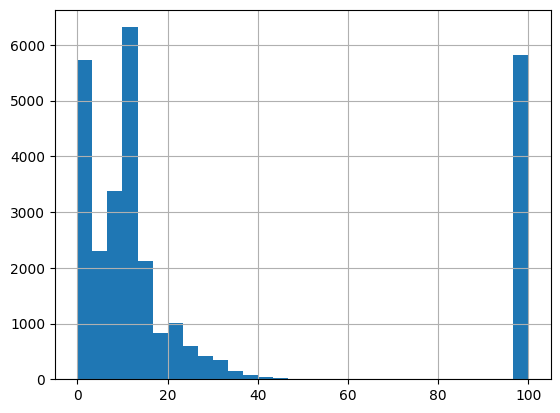

In [89]:
df.loc[(df['role_name'] == "Goalkeeper")]['positions_0_x'].hist(bins=30)

<Axes: >

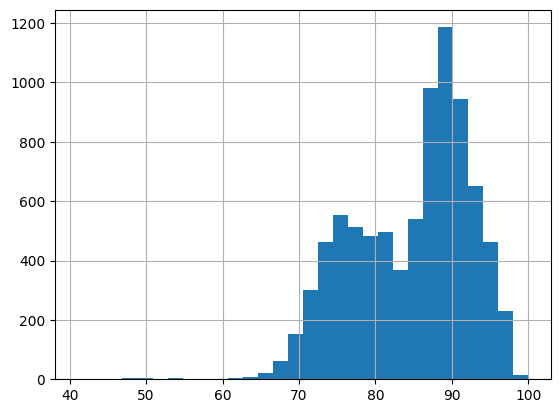

In [93]:
df.loc[(df['eventName'] == "Shot")]['positions_0_x'].hist(bins=30)

### Create features

In [128]:
OPPONENT_GOAL_X = 100
OPPONENT_GOAL_Y = 50

def forward_or_backward(row):
    if row['positions_0_x'] < row['positions_1_x']:
        return 'F'
    elif row['positions_0_x'] > row['positions_1_x']:
        return 'B'
    else:
        return '-'
    
def calc_degree(row):
    dx = row['positions_0_x'] - row['positions_1_x']
    dy = row['positions_0_y'] - row['positions_1_y']
    return math.degrees(math.atan2(dy, dx))

def calc_degree_before(row):
    dx = row['positions_0_x'] - OPPONENT_GOAL_X
    dy = row['positions_0_y'] - OPPONENT_GOAL_Y
    return math.degrees(math.atan2(dy, dx))

def calc_degree_after(row):
    dx = row['positions_1_x'] - OPPONENT_GOAL_X
    dy = row['positions_1_y'] - OPPONENT_GOAL_Y
    return math.degrees(math.atan2(dy, dx))

def is_penalty_box_before(row):
    if ((row['positions_0_x'] > 84.25) and (row['positions_0_y'] > 20.25) and (row['positions_0_y'] < 79.75)):
        return 1
    else:
        return 0
    
def is_penalty_box_after(row):
    if ((row['positions_1_x'] > 84.25) and (row['positions_1_y'] > 20.25) and (row['positions_1_y'] < 79.75)):
        return 1
    else:
        return 0

In [130]:
# Distance of event
df['event_dist'] = np.sqrt((df['positions_1_x'] - df['positions_0_x']) ** 2 + (df['positions_1_y'] - df['positions_0_y']) ** 2)

# Distance from opponent goal before event
df['before_event_DFG'] = np.sqrt((OPPONENT_GOAL_X - df['positions_0_x']) ** 2 + (OPPONENT_GOAL_Y - df['positions_0_y']) ** 2)

# Distance from opponent goal after event
df['after_event_DFG'] = np.sqrt((OPPONENT_GOAL_X - df['positions_1_x']) ** 2 + (OPPONENT_GOAL_Y - df['positions_1_y']) ** 2)

# Angle of event - not sure if needed, goal angles may be enough
# df['event_angle'] = df.apply(calc_degree, axis=1)

# Angle to opponent goal before event
df['before_event_goalAngle'] = df.apply(calc_degree_before, axis=1)

# Angle to opponent goal after event
df['after_event_goalAngle'] = df.apply(calc_degree_after, axis=1)

# Forward or backward event (for example: pass)
df['event_F/B'] = df.apply(forward_or_backward, axis=1)

# In penalty box before event
df['before_event_in_penalty_box'] = df.apply(is_penalty_box_before, axis=1)

# In penalty box after event
df['after_event_in_penalty_box'] = df.apply(is_penalty_box_after, axis=1)

In [131]:
df[['event_dist', 'before_event_DFG', 'after_event_DFG', 'before_event_goalAngle', 'after_event_goalAngle', 'event_F/B', 'before_event_in_penalty_box', 'after_event_in_penalty_box']]

,event_dist,before_event_DFG,after_event_DFG,before_event_goalAngle,after_event_goalAngle,event_F/B,before_event_in_penalty_box,after_event_in_penalty_box
0,34.132096,51.009803,74.464757,-178.876697,157.912828,B,0,0
1,20.223748,74.464757,55.009090,157.912828,152.969140,F,0,0
2,16.492423,55.009090,68.308125,152.969140,162.095552,B,0,0
3,24.738634,68.308125,74.202426,162.095552,142.666804,F,0,0
4,31.780497,74.202426,47.201695,142.666804,126.384352,F,0,0
...,...,...,...,...,...,...,...,...
643145,120.929732,101.607086,50.000000,-169.796026,90.000000,F,0,0
643146,54.341513,50.000000,12.369317,90.000000,-165.963757,B,0,1
643147,3.605551,88.051122,86.000000,178.047491,180.000000,F,0,0
643148,3.605551,12.369317,14.000000,-165.963757,180.000000,B,1,1


# Imputation & Normalizing

In [16]:
# takes a long time to run, uncomment only if needed
# sb.heatmap(df.isnull())

In [17]:
nan_values = df.columns[df.isna().any()].tolist()
for col in df:
    if col in nan_values:
        print(col)
        #print(df[col].value_counts(normalize=True))
        print('Percentage of nan values: ' + str(df[col].isna().sum()/df.shape[0]) + '\n')

tags_0_id
Percentage of nan values: 0.0955935629324419

tags_1_id
Percentage of nan values: 0.6287491253984296

tags_2_id
Percentage of nan values: 0.8819404493508513

tags_3_id
Percentage of nan values: 0.9813371686231828

tags_4_id
Percentage of nan values: 0.9974329472129363

tags_5_id
Percentage of nan values: 0.9998274119567753

positions_1_y
Percentage of nan values: 0.00018347197387856643

positions_1_x
Percentage of nan values: 0.00018347197387856643

weight
Percentage of nan values: 0.07468086760475784

firstName
Percentage of nan values: 0.07468086760475784

middleName
Percentage of nan values: 0.07468086760475784

lastName
Percentage of nan values: 0.07468086760475784

currentTeamId
Percentage of nan values: 0.07468086760475784

birthDate
Percentage of nan values: 0.07468086760475784

height
Percentage of nan values: 0.07468086760475784

wyId
Percentage of nan values: 0.07468086760475784

foot
Percentage of nan values: 0.07468086760475784

shortName
Percentage of nan values:

In [18]:
#to_be_deleted = []
#df.drop(columns=to_be_deleted, inplace=True)